#1. 환경구축

- pip install list

In [1]:
!pip install wordcloud
!pip install transformers
!pip install keras_preprocessing
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 5.2 MB/s eta 0:00:00


- Transformer 버전이 안 맞는 경우
  - PartialState 오류 발생 시 아래 코드 설치 후 런타임 재실행

In [2]:
#!pip install transformers==4.28.0

#2. 데이터 전처리

In [3]:
import pandas as pd
import urllib.request

In [4]:
# 영화 리뷰 정보 다운로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7b975e76eec0>)

In [5]:
# Pandas로 데이터 불러오기
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
# 데이터 사이즈 확인
train_data.shape, test_data.shape

((150000, 3), (50000, 3))

- 데이터 확인

In [6]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


- 데이터의 결측치 확인

데이터의 결측치가 document 부분에서 존재하기는 하지만, 타깃 레이블인 label 칼럼에는 존재하지 않는다. 아무래도 리뷰를 입력하기 귀찮아 만족 여부만 답한 사람도 있을 것이다. 영화에 대해 세부적인 리뷰가 없는 것에 대해서는 아쉽지만, 그럼에도 불구하고 만족도에 대한 정보는 타깃에 있으므로 일단 결측치는 제거하지 않는다.

In [8]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [9]:
test_data.isnull().sum()

id          0
document    3
label       0
dtype: int64

- 타깃의 클래스 수 확인하기

In [10]:
train_data["label"].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [11]:
test_data["label"].value_counts()

1    25173
0    24827
Name: label, dtype: int64

- 클래스 불균형 (class imbalance) 확인하기

[Text(0.5, 1.0, 'Customer Satisfaction(Train)')]

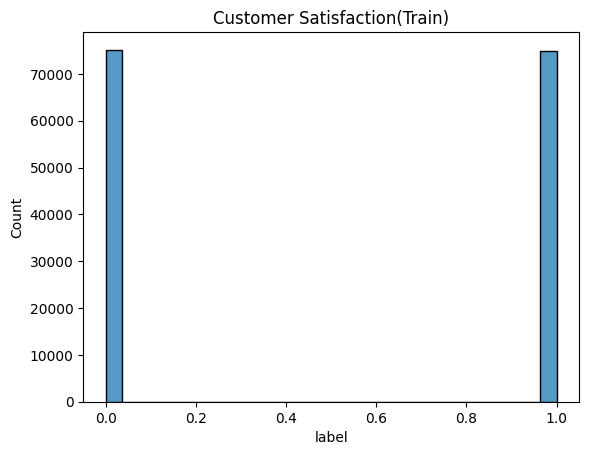

In [12]:
import seaborn as sns

sns.histplot(train_data["label"]).set(title="Customer Satisfaction(Train)")

- WordCloud를 활용하여 데이터 시각화

위 WordCloud를 보니 "정말", "영화", "진짜" 등의 단어가 가장 많이 나온 것을 알수있다. 하지만 엄밀히 따지자면, 이 단어들은 직접적으로 한 사람의 감정을 나타내기 보다는 특정한 대상이나, 그 대상을 확대하여 표현하기 위한 부사들이다. 이 단어들은 직접적으로 감정을 분석하는데 있어 도움이 되지 않기 때문에 이러한 단어들은 Stopwords로써 필터링할 수 있다.

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
# %matplotlib inline

In [14]:
# 한글 폰트 준비
urllib.request.urlretrieve("http://macsplex.com/?module=file&act=procFileDownload&file_srl=2851&sid=ea4a36b12467c4446c21e70762c7d10f&module_srl=2822g", filename="AppleGothic.ttf")

('AppleGothic.ttf', <http.client.HTTPMessage at 0x7b975326ed70>)

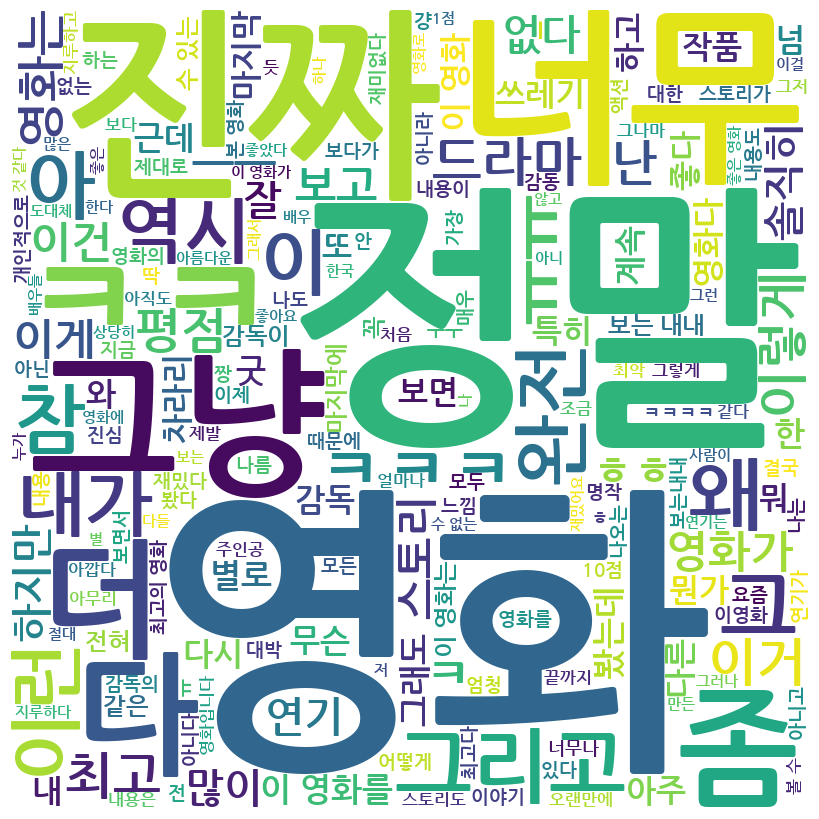

In [15]:
# Stopwords 및 특수문자 필터링을 위한 준비

comment_words = ''
stopwords = set(STOPWORDS)

tokenized_text = []

# 문장 데이터를 단어화하기
for val in train_data["document"]:

  # 문장을 string으로 만들기
  val = str(val)

  # 문장을 쪼개기
  tokens = val.split()

  tokenized_text.append(tokens)
  comment_words += " ".join(tokens) + " "

wordcloud = WordCloud(width = 800, height = 800,
                font_path='AppleGothic.ttf',
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [16]:
# 필터링할 추가적인 stopwords들 정의
stopwords_2 = ["영화", "진짜", "정말", "이거", "그냥", "너무", "영화가", "영화는",
             "이거", "이게", "이건", "영화의", "어떤", "아주", "계속", "영화다",
             "영화를", "그리고"
]

- 토큰화 및 불용어 제거
모든 문장을 단어로 토큰화하고, 이전에 새롭게 정의한 불용어를 제거한다.

In [17]:
tokenized_text[0]

['아', '더빙..', '진짜', '짜증나네요', '목소리']

In [18]:
len(tokenized_text)

150000

In [19]:
# 새로운 불용어와 기존 불용어 필터링하기

def filter_stopwords(tokenized_text, stopwords_2):
  tokenized_filtered = []

  for i in tokenized_text:
    for word in i:
      if word not in stopwords and word not in stopwords_2:
        tokenized_filtered.append(word)

  return tokenized_filtered

In [20]:
tokenized_filtered = filter_stopwords(tokenized_text, stopwords_2)

In [21]:
# 필터링 되었는지 확인
tokenized_filtered[0:10]

['아',
 '더빙..',
 '짜증나네요',
 '목소리',
 '흠...포스터보고',
 '초딩영화줄....오버연기조차',
 '가볍지',
 '않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소']

In [22]:
len(tokenized_filtered)

1083270

In [23]:
# 각 단어가 얼마나 나왔는지 카운트해보기

import operator

def word_count(tokenized_data):
  word_counter = {}

  for i in tokenized_data:
    if i in word_counter.keys():
      word_counter[i] += 1
    else:
      word_counter[i] = 1

  # 많이 나온 순서대로 정렬

  sorted_dict = dict( sorted(word_counter.items(),
                           key=operator.itemgetter(1), reverse=True))

  return sorted_dict

In [24]:
tokenized_dict = word_count(tokenized_filtered)

In [25]:
# 가장 상위 20개의 단어 보기
def top_20(tokenized_dict):
  top_20_words = list(tokenized_dict.items())[:20]
  return top_20_words

top_20(tokenized_dict)

[('이', 5059),
 ('영화.', 3598),
 ('왜', 3285),
 ('더', 3260),
 ('이런', 3249),
 ('수', 2945),
 ('잘', 2644),
 ('다', 2615),
 ('보고', 2557),
 ('좀', 2449),
 ('그', 2421),
 ('본', 2298),
 ('최고의', 2219),
 ('ㅋㅋ', 2019),
 ('내가', 2000),
 ('없는', 1957),
 ('이렇게', 1828),
 ('완전', 1780),
 ('평점', 1760),
 ('봤는데', 1746)]

In [26]:
stopwords_2.extend(["이", "이렇게", "더", "수", "다", "그", "내가", "이렇게",
               "완전", "봤는데", "영화.", "평점", "평점이", "왜", "이런", "본",
               "보고", "잘", "보는", "내", "다시", "난", "연기", "한", "것", "하는", "또",
                "역시", "좀", "참", "많이", "없는", "있는"
])

In [27]:
tokenized_filtered = filter_stopwords(tokenized_text, stopwords_2)

len(tokenized_filtered)

1015418

In [28]:
tokenized_dict = word_count(tokenized_filtered)

In [29]:
# 가장 상위 20개의 단어 보기
top_20(tokenized_dict)

[('최고의', 2219),
 ('ㅋㅋ', 2019),
 ('좋은', 1726),
 ('재밌게', 1343),
 ('쓰레기', 1295),
 ('아', 1204),
 ('드라마', 1186),
 ('꼭', 1181),
 ('가장', 1178),
 ('보면', 1176),
 ('ㅋㅋㅋ', 1108),
 ('마지막', 1070),
 ('스토리', 1020),
 ('무슨', 999),
 ('ㅋ', 989),
 ('없고', 981),
 ('.', 981),
 ('볼', 959),
 ('ㅠㅠ', 958),
 ('같은', 956)]

- 키워드 분석하기

이쯤에서 감정이 드러난 단어들을 하나의 그룹으로 묶어보자. 즉, 키워드만을 추려서 특정한 감정을 나타내는 그룹으로 묶어본다. 여기서 주의할 것은 "ㅋㅋㅋ", "ㅋㅋ", "ㅋ"의 의미가 서로 다를 수 있다는 것이다

In [30]:
# 감정이 드러난 단어들을 묶어보기

emotion_dict = {"최고의": "극찬", "ㅋㅋ": "웃음", "좋은": "기쁨", "재밌게": "흥미",
                "쓰레기": "혐오", "ㅋㅋㅋ": "웃음", "ㅋ": "무심", "ㅠㅠ": "슬픔"
}

In [31]:
from collections import defaultdict, OrderedDict

emotions_dict = defaultdict(int)

emotions_list = []

for k, v in tokenized_dict.items():
  for key, value in emotion_dict.items():
    if k == key:
      emotions_list.append((value, v))

for k, v in emotions_list:
  if k in emotions_dict:
    emotions_dict[k] += v
  else:
    emotions_dict[k] = v

emotions_dict = OrderedDict(sorted(emotions_dict.items(),
                            key=lambda item: item[1],
                            reverse=True))

emotions_dict

OrderedDict([('웃음', 3127),
             ('극찬', 2219),
             ('기쁨', 1726),
             ('흥미', 1343),
             ('혐오', 1295),
             ('무심', 989),
             ('슬픔', 958)])

In [32]:
# Plotly로 시각화

# Pie Chart
import plotly.express as px

emotions = pd.Series(emotions_dict)

fig = px.pie(emotions, values=emotions, names=emotions.index, title="가장 두드러지게 나타난 감정", hover_data=[emotions], labels=emotions.index)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:137: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return args["labels"][column]
/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:137: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return args["labels"][column]


In [33]:
# Bar chart
fig = px.bar(emotions, x=emotions.index, y=emotions, title="가장 두드러지게 나타난 감정")
fig.show()

가장 많이 나온 키워드들을 바탕으로 정리해본 결과, "ㅋㅋㅋ", "ㅋㅋ" 등의 의성어로 대표되는 웃음의 감정이 가장 두드러지게 드러났다. 일상 생활에서도 이러한 용어는 무언가 재치있거나 재미있는 것을 발견했을 때 자주 사용이 된다는 것을 감안하면, 아마 재미위주의 B급 감성 코미디 컨텐츠가 이러한 반응을 주로 이끌어내었을 것이다.

또한 "최고의"라는 용어는 "극찬"의 표현으로써, 어떠한 분야에서 가장 두드러지거나 굉장한 평가를 이끌어냈을 때 쓰는 말이다. 요즘에는 "최고의 액션 영화", "최고의 판타지 영화", "올해 최고의 영화" 등 무언가 특정한 장르에서 상당히 좋게 평가되는 장르의 영화들을 이런식으로 많이 지칭한다. 그렇다는 것은, 아무래도 사람들의 입소문을 타고 유명해진 영화들이나, 일반 사람들도 워낙 유명해 많이 들어본 영화들이 아무래도 이러한 평가를 받았을 수 있다. 예를 들어, <미션 임파서블> 시리즈 같은 액션 영화, <반지의 제왕> 같은 판타지 영화, 거장 크리스토퍼 놀란 감독의 대작 <인터스텔라>나, 또는 최근에 아카데미에서 극찬을 받은 우리나라 영화 <기생충>등, 특정 장르를 대표하거나 감독의 색깔이 두드러지게 드러나는 영화들이 있을 수 있다.

또한 다음 감정으로 "기쁨"과 "흥미"가 두드러지게 나왔는데, 아무래도 관객으로 하여금 흥미진진한 스토리나 반전 등의 영화로 무장하거나, 권선징악의 다소 진부한 형태를 따르더라도 흥미로운 스토리로 전개되는 영화들에 이런 반응을 보일 수 있다. 엄청나게 큰 제작비로 만들어진 것은 아니지만, 탄탄한 스토리로 어필하는 부류의 영화들, 예를 들어, 이전에 언급한 <기생충>, 지금까지도 많이 회자되는 <노인을 위한 나라는 없다>, 또는 스티븐 스필버그 감독의 역작 < A.I > 같은 영화를 예로 들 수 있다.

또한 이전에 "좋은"이라는 키워드도 많이 나왔다는 것을 확인했다. 일반적으로 "좋은 영화"라고 이야기 할때 대부분 단순히 재미를 떠나 관객으로 하여금 어떠한 메시지를 주는 영화들이 있을 수 있다. 내가 최근에 본 < 굿윌헌팅(Good Will Hunting)>, <트루먼 쇼(Truman Show)>, <델마와 루이스(Thelma and Louise)>같은, 흥미로운 스토리를 가지면서도 어떠한 메시지가 담긴 영화들이 될 수 있다.

"혐오"와 "무심"같은 부정적인 감정은 전체에서 약 20%가까이 나왔는데, 그만큼 자신들이 본 콘텐츠에 대해 거부감을 갖거나 만족하지 못한 사람도 많았다는 것을 알려준다. 영화 리뷰를 평소 관심있게 보다보면, 개봉전 부터 큰 기대를 안고 보았으나, 영화가 생각만큼 재미가 없었을 때 이런 반응이 자주 나오곤 한다. 주로 많은 기대를 받고 상당한 비용을 들여 재작했으나, 그 기대에 한참 미치지 못한 블록버스터 급의 영화들에서 이런 반응이 많이 나올 수 있다. 예를 들어 실사화된 <드래곤 볼>, DC코믹스의 히어로들의 세계관을 보여준 <저스티스 리그>, 우리나라에서도 많은 악평을 낳은 영화 < 7광구 > 등이 대표적으로 이러한 반응을 이끌어 냈을 영화들이었을 수 있다. 즉, 소위 마케팅만 잘 된 속빈 강정같은 작품을 본 후에 이런 감정들이 생기기 쉽다. 이러한 감정들은 아무래도 왓챠의 비즈니스에 있어서 부정적인 감정들이고, 20%의 숫자는 적지 않기 때문에, 이러한 반응을 이끌어 낼만한 완성도가 떨어지는 영화들에 대해서는 판권 계약의 우선 순위에서 조금 더 뒤로 미룰 필요가 있다.

마지막으로 "슬픔"의 감정도 존재했는데, 정말 감동적이면서 눈물 샘을 자극하는 영화들이 이런 감정을 이끌어 냈을 수 있다. 재미있으면서도 감동적이기로 유명했던 영화 < 7번방의 선물 >, 한 아버지의 눈물겨운 성장스토리인 <행복을 찾아서>, 로맨틱의 끝판왕 <타이타닉>과 같은 영화들이 사람들의 눈물 샘을 많이 자극한 대표적인 영화라고 할 수 있다.

지금까지 키워드로 언급된 감정들과, 각 감정을 이끌어낼 수 있는 영화들을 예로들었다. 예를 든 것처럼 왓챠에서도 만약 이러한 감정 키워드들과 관련이 깊은 영화들을 정리해서 추천한다면, 훨씬 더 이러한 감정들을 자극할 수 있을 것이다. 각 감정을 좀 더 느끼길 원하는 유저들의 만족도를 조금 더 끌어올리면서 유저들에게 좀 더 최적화된 컨텐츠를 제공할 수 있을 것이다.

#4. 모델 import

In [34]:
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, Adafactor, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

CLS 및 SEP 태그를 달아주어야 했기 때문에, 최초의 데이터를 활용했다.
Bert multilingual 모델에 있는 tokenizer를 활용하여 토큰화한다.

In [35]:
# BERT에 맞는 Tag 달아주기
bert_text = []

for i in train_data['document']:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  bert_text.append(bert)

bert_text[:5]

[['[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]'],
 ['[CLS] 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나 [SEP]'],
 ['[CLS] 너무재밓었다그래서보는것을추천한다 [SEP]'],
 ['[CLS] 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정 [SEP]'],
 ['[CLS] 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다 [SEP]']]

In [36]:
test_text = []

for i in test_data['document']:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  test_text.append(bert)

test_text[:5]

[['[CLS] 굳 ㅋ [SEP]'],
 ['[CLS] GDNTOPCLASSINTHECLUB [SEP]'],
 ['[CLS] 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 [SEP]'],
 ['[CLS] 지루하지는 않은데 완전 막장임... 돈주고 보기에는.... [SEP]'],
 ['[CLS] 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠?? [SEP]']]

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_data = []
for i in bert_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_data.append(tokens)

print(tokenized_data[0:10])

[['[CLS]', '아', '더', '##빙', '.', '.', '진', '##짜', '짜', '##증', '##나', '##네', '##요', '목', '##소', '##리', '[SEP]'], ['[CLS]', '[UNK]', '.', '.', '.', '포', '##스터', '##보', '##고', '초', '##딩', '##영', '##화', '##줄', '.', '.', '.', '.', '오', '##버', '##연', '##기', '##조', '##차', '가', '##볍', '##지', '않', '##구', '##나', '[SEP]'], ['[CLS]', '[UNK]', '[SEP]'], ['[CLS]', '교', '##도', '##소', '이야기', '##구', '##먼', '.', '.', '솔', '##직', '##히', '재', '##미', '##는', '없다', '.', '.', '평', '##점', '조', '##정', '[SEP]'], ['[CLS]', '사', '##이', '##몬', '##페', '##그', '##의', '익', '##살', '##스', '##런', '연', '##기가', '돋', '##보', '##였던', '영화', '!', '스', '##파', '##이', '##더', '##맨', '##에서', '늙', '##어', '##보', '##이', '##기', '##만', '했', '##던', '커', '##스', '##틴', '던', '##스트', '##가', '너', '##무', '##나', '##도', '이', '##뻐', '##보', '##였다', '[SEP]'], ['[CLS]', '막', '걸', '##음', '##마', '[UNK]', '3', '##세', '##부터', '초', '##등학교', '1', '##학', '##년', '##생', '##인', '8', '##살', '##용', '##영', '##화', '.', '[UNK]', '.', '.', '.', '별', '##반', '##개', '##

In [38]:
tokenized_test_data = []
for i in test_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_test_data.append(tokens)

print(tokenized_test_data[0:5])

[['[CLS]', '굳', '[UNK]', '[SEP]'], ['[CLS]', 'G', '##D', '##NT', '##OP', '##CL', '##AS', '##SI', '##NT', '##H', '##EC', '##L', '##UB', '[SEP]'], ['[CLS]', '뭐', '##야', '이', '평', '##점', '##들은', '.', '.', '.', '.', '나', '##쁘', '##진', '않', '##지만', '10', '##점', '짜', '##리는', '더', '##더', '##욱', '[UNK]', '[SEP]'], ['[CLS]', '지', '##루', '##하지', '##는', '않은', '##데', '완', '##전', '막', '##장', '##임', '.', '.', '.', '돈', '##주', '##고', '보', '##기에', '##는', '.', '.', '.', '.', '[SEP]'], ['[CLS]', '3D', '##만', '아', '##니', '##었', '##어', '##도', '별', '다', '##섯', '개', '줬', '##을', '##텐', '##데', '.', '.', '왜', '3D', '##로', '나', '##와', '##서', '제', '심', '##기를', '불', '##편', '##하게', '하', '##죠', '?', '?', '[SEP]']]


- padding

In [39]:
input_ids = []
for i in tokenized_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids.append(ids)

print(input_ids[0])

[101, 9519, 9074, 119005, 119, 119, 9708, 119235, 9715, 119230, 16439, 77884, 48549, 9284, 22333, 12692, 102]


In [40]:
input_ids_test = []
for i in tokenized_test_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids_test.append(ids)

print(input_ids_test[0])

[101, 8911, 100, 102]


In [41]:
max_len = 128
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9519,   9074, 119005,    119,    119,   9708, 119235,
         9715, 119230,  16439,  77884,  48549,   9284,  22333,  12692,
          102,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [42]:
input_ids_test = pad_sequences(input_ids_test, maxlen=max_len, dtype='long', truncating='post', padding='post')
input_ids_test[0]

array([ 101, 8911,  100,  102,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

- masking

In [43]:
attention_masks = []

for ids in input_ids:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks.append(ids_mask)

print(attention_masks[0])
print(len(attention_masks[0]))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
128


In [44]:
attention_masks_test = []

for ids in input_ids_test:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks_test.append(ids_mask)

print(attention_masks_test[0])
print(len(attention_masks_test[0]))

[1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
128


- train / test 데이터 분리

In [45]:
X_train, X_val, y_train, y_val = train_test_split(
    input_ids, train_data['label'].values, random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=42,
                                                       test_size=0.2)

In [46]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((120000, 128), (30000, 128), (120000,), (30000,))

- fine-tuning 을 위한 데이터 분리
- 모델링을 위해 tensor로 변환할 데이터 분리

In [47]:
X_train_tune = X_train
y_train_tune = y_train
X_val_tune = X_val
y_val_tune = y_val

In [48]:
X_test_tensor = input_ids_test
y_test_tensor = test_data["label"].values
test_masks = attention_masks_test

- pytorch 변환
  - input_ids
  - target label
  - masking

In [49]:
# PyTorch로 변환
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
train_masks = torch.tensor(train_masks)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)
validation_masks = torch.tensor(validation_masks)

In [50]:
X_test_tensor = torch.tensor(X_test_tensor)
y_test_tensor = torch.tensor(y_test_tensor)
test_masks = torch.tensor(attention_masks_test)

- batch size 지정

In [51]:
batch_size = 32

train = TensorDataset(X_train_tensor, train_masks, y_train_tensor)
train_sampler = RandomSampler(train)

val = TensorDataset(X_val_tensor, validation_masks, y_val_tensor)
val_sampler = SequentialSampler(val)


test = TensorDataset(X_test_tensor, test_masks, y_test_tensor)
test_sampler = RandomSampler(test)

train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val, sampler=val_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test, sampler=test_sampler, batch_size=batch_size)

- GPU 사용가능여부 확인

In [52]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


- Fine Tuning

In [53]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [54]:
for param in model.base_model.parameters():
    param.requires_grad = False

In [55]:
from sklearn.model_selection import train_test_split
train_queries, val_queries, train_docs, val_docs, train_labels, val_labels = train_test_split(
    train_data["id"].apply(str).tolist(),
    train_data["document"].apply(str).tolist(),
    train_data["label"].tolist(),
    test_size=.2
)

- 데이터 토큰화 후 인코딩

In [56]:
from transformers import BertTokenizerFast

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(train_queries, train_docs, truncation=True, padding='max_length', max_length=max_len)
val_encodings = tokenizer(val_queries, val_docs, truncation=True, padding='max_length', max_length=max_len)

In [57]:
import torch

class Cord19Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Cord19Dataset(train_encodings, train_labels)
val_dataset = Cord19Dataset(val_encodings, val_labels)

- Finetuning

In [58]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    weight_decay=0,               # strength of weight decay
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.
)


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.688400,0.686813
2,0.685200,0.684191
3,0.684300,0.683353


TrainOutput(global_step=11250, training_loss=0.687041754828559, metrics={'train_runtime': 3567.5066, 'train_samples_per_second': 100.911, 'train_steps_per_second': 3.153, 'total_flos': 2.36799949824e+16, 'train_loss': 0.687041754828559, 'epoch': 3.0})

- 모델 학습

In [59]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값,
                )
# 에폭수
epochs = 3

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# Learning rate decay를 위한 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [60]:
# 정확도 계산 함수
def accuracy_measure(y_pred, y):
    pred_flattened = np.argmax(y_pred, axis=1).flatten()
    y_flattened = y.flatten()
    return np.sum(pred_flattened == y_flattened) / len(y_flattened)

# 시간 표시 함수
def time_elapsed(elapsed):
    # 반올림
    elapsed = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed))

In [61]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

In [ ]:
# 본격적인 학습
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================


    # 현재 훈련 조건 표시
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
          elapsed = time_elapsed(time.time() - t0)
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행
        outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(time_elapsed(time.time() - t0)))
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)

        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # 그래디언트 계산 안함
        with torch.no_grad():
          # Forward 수행
          outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

          # 로스 구함
          logits = outputs[0]

          # CPU로 데이터 이동
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # 출력 로짓과 라벨을 비교하여 정확도 계산
          tmp_eval_accuracy = accuracy_measure(logits, label_ids)
          eval_accuracy += tmp_eval_accuracy
          nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(time_elapsed(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch   500  of  3,750.    Elapsed: 0:01:52.


In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = time_elapsed(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)

    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = accuracy_measure(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(time_elapsed(time.time() - t0)))

In [ ]:
# 실제 테스트 데이터 클래스 균형 보기
sns.histplot(test_data["label"]).set(title="Customer Satisfaction(Test)")

우리가 실험하고자 하는 가설은 "왓챠의 콘텐츠에 만족하는 고객과 만족하지 못하는 고객의 수가 균등하다."라는 것이었다. 타깃 데이터의 실제 분포는 이 가설에 맞게 끔 설정되었고, 모델은 64% 정도의 정확도로 실제 타깃을 예측했다. 모델은 귀무가설이 이 정도의 확률로 유의하다고 예측한 것이다. 따라서, 귀무가설을 기각하지 않게 되었다. 만족하는 유저들 만큼, 만족하지 못하는 유저들이 있다는 것이 어느 정도 유의하다고 볼 수 있다는 의미다.

<br>
<br>

# **새로운 문장 테스트**

In [ ]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [ ]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)

    # 그래디언트 계산 안함
    with torch.no_grad():
        # Forward 수행
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    # 출력 로짓 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [ ]:
logits = test_sentences(['연기는 별로지만 재미 하나는 끝내줌!'])

# print(logits)
print(np.argmax(logits))

In [ ]:
logits = test_sentences(['주연배우가 아깝다. 총체적 난국...'])

# print(logits)
print(np.argmax(logits))

학습한 모델을 가지고 실제 문장을 넣어봤습니다. 출력 로짓은 소프트맥스가 적용되지 않은 상태입니다. argmax로 더 높은 값의 위치를 라벨로 설정하면 됩니다. 0은 부정, 1은 긍정입니다. 위와 같이 새로운 문장에도 잘 분류를 하고 있습니다.
<br>
<br>
<br>